# FACIAL RECOGNITION SYSTEM.

## System Outline:

### 1. Load and Prepare the LFW Dataset.
- Load the deep funneled LFW dataset and select 20 images.  

- Preprocess images for face detection.  

### 2. Implement Face Detection.
- Use Haar cascades for initial face detection.

- Use a deep learning-based face detector (e.g., OpenCV DNN or dlib) for comparison.  

- Store confidence scores in the database.  

### 3. SQLite Database Setup 
- Create a table to store clock-in and clock-out timestamps.  

- Store detection confidence scores from both models.  

### 4. Implement Clock-In and Clock-Out System. 
- Enforce lateness penalties (extra work time based on tardiness).  

- Handle lunch breaks and penalties for late returns.  
- Distribute unclocked work hours across multiple days if needed.  

### 5. Test and Visualize 
- Select 10 new images to simulate different lateness scenarios.  

- Log and compare detection accuracy over time.  

- Visualize confidence scores for Haar cascades vs. deep learning-based detector.

# Imports.

In [52]:
import os
import cv2
import dlib
import time
import random
import sqlite3
import requests
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from datetime import datetime, timedelta

# 1. Load Dataset.

In [53]:
# Path to the dataset
DATASET_PATH = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# List all individuals in the dataset
individuals = os.listdir(DATASET_PATH)

# Randomly select 20 individuals
selected_individuals = random.sample(individuals, 20)

# Create a directory to store selected images
os.makedirs('/kaggle/working/selected_images', exist_ok=True)

# Initialize a list to hold image paths
selected_images = []

# Loop through each selected individual
for person in selected_individuals:
    person_path = os.path.join(DATASET_PATH, person)
    # List all images for the individual
    images = os.listdir(person_path)
    # Randomly select one image for the individual
    selected_image = random.choice(images)
    # Define the full path to the selected image
    image_path = os.path.join(person_path, selected_image)
    # Open, convert to grayscale, and save the image
    with Image.open(image_path) as img:
        gray_img = img.convert('L')  # Convert to grayscale
        # Save the processed image
        gray_img.save(f'/kaggle/working/selected_images/{person}_{selected_image}')
        # Append the path to the list
        selected_images.append(f'/kaggle/working/selected_images/{person}_{selected_image}')

# Display some of the selected images

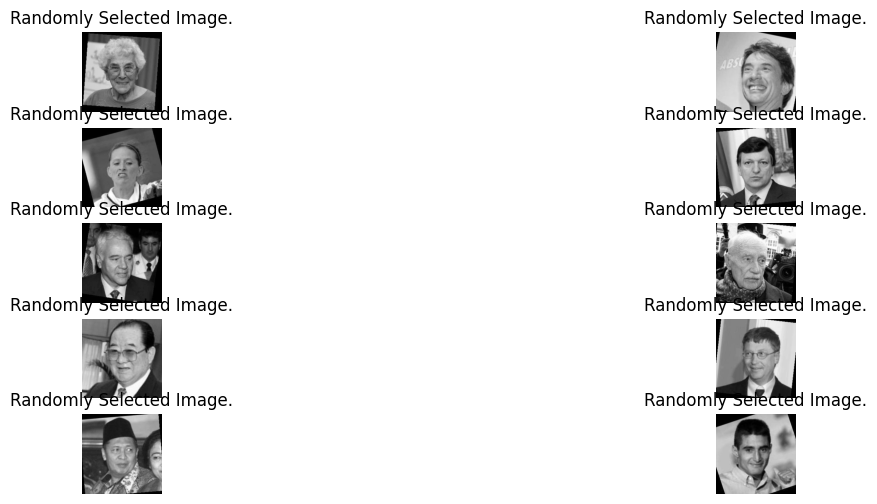

In [54]:
fig, axes = plt.subplots(5, 2, figsize=(15, 6))

for ax, img_path in zip(axes.ravel(), selected_images[:10]):
    img = Image.open(img_path)
    ax.set_title('Randomly Selected Image.')
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()

# 1. Define the FaceDetector Base Class.

- This will be the parent class for both the Haar cascade and DNN-based detectors.

In [55]:
class FaceDetector(ABC):
    """
    Base class for face detection models.
    """

    @abstractmethod
    def detect_faces(self, image):
        """
        Detect faces in an image and return bounding boxes with confidence scores.
        """
        pass

# 2. Implement Haar Cascade Face Detector.

In [56]:
class HaarCascadeDetector(FaceDetector):
    """
    Face detector using Haar cascades.
    """

    def __init__(self, cascade_path="haarcascade_frontalface_default.xml"):
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)

    def detect_faces(self, image):
        """
        Detect faces using Haar cascades.
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        
        results = []
        for (x, y, w, h) in faces:
            results.append({"box": (x, y, w, h), "confidence": None})  # Haar cascades don't return confidence

        return results

#  3. Implement OpenCV DNN-Based Face Detector.

In [57]:
CONFIG_PATH = "/kaggle/input/dnn-face-recognition-model/deploy.prototxt.txt"
MODEL_PATH = "/kaggle/input/dnn-face-recognition-model/res10_300x300_ssd_iter_140000.caffemodel"

class DeepLearningDetector(FaceDetector):
    """
    Face detector using OpenCV DNN model.
    """

    def __init__(self, model_path=MODEL_PATH,
                 config_path=CONFIG_PATH, confidence_threshold=0.5):
        self.net = cv2.dnn.readNetFromCaffe(config_path, model_path)
        self.confidence_threshold = confidence_threshold

    def detect_faces(self, image):
        """
        Detect faces using OpenCV DNN model.
        """
        h, w = image.shape[:2]
        blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
        self.net.setInput(blob)
        detections = self.net.forward()

        results = []
        
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > self.confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x, y, x_max, y_max) = box.astype("int")
                results.append({"box": (x, y, x_max - x, y_max - y), "confidence": confidence})

        return results

# 4. Implement the SQLite Database Manager.

In [58]:
class DatabaseManager:
    """
    Handles SQLite database operations for face recognition records.
    """

    def __init__(self, db_path="attendance.db"):
        self.conn = sqlite3.connect(db_path, check_same_thread=False)
        self.cursor = self.conn.cursor()
        self.create_table()

    def create_table(self):
        """
        Create a table for attendance records with model tracking.
        """
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS attendance (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT,
                timestamp TEXT,
                model TEXT, 
                confidence REAL,
                lateness INTEGER
            )
        """)
        
        self.conn.commit()

    def log_clock_in(self, name, timestamp, model, confidence, lateness):
        """
        Log a clock-in record with the model used.
        """
        self.cursor.execute(
            "INSERT INTO attendance (name, timestamp, model, confidence, lateness) VALUES (?, ?, ?, ?, ?)",
            (name, timestamp, model, confidence, lateness)
        )
        self.conn.commit()

    def log_clock_out(self, name, clock_out_time):
        """
        Log clock-out and return lateness for penalties.
        """
        self.cursor.execute("SELECT timestamp, lateness FROM attendance WHERE name=? ORDER BY timestamp DESC LIMIT 1", (name,))
        record = self.cursor.fetchone()

        if record:
            clock_in_time, lateness = record
            self.cursor.execute(
                "INSERT INTO attendance (name, timestamp, model, confidence, lateness) VALUES (?, ?, ?, ?, ?)",
                (name, clock_out_time, "Clock-Out", None, lateness)
            )
            self.conn.commit()
            return lateness, None
        
        return None, None

    def fetch_records(self):
        """
        Retrieve all detection records.
        """
        self.cursor.execute("SELECT * FROM attendance")
        
        return self.cursor.fetchall()

In [59]:
def create_attendance_table():
    """
    Create Attendance table for the database.
    """
    conn = sqlite3.connect("attendance.db")
    cursor = conn.cursor()
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS attendance_log (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            person_name TEXT,
            clock_in_time TEXT,
            clock_out_time TEXT,
            model TEXT
            confidence_score REAL,
            lateness_minutes INTEGER
        )
    """)
    
    conn.commit()
    conn.close()
    print("Table 'attendance_log' created or verified successfully.")

# Run table creation
create_attendance_table()

Table 'attendance_log' created or verified successfully.


# 5. Implement the Face Recognition System.

In [60]:
class FaceRecognitionSystem:
    """
    Manages face recognition, clock-in, clock-out, and lateness penalties.
    """

    def __init__(self, dataset_path, database):
        self.dataset_path = dataset_path
        self.db = database
        self.haar_detector = HaarCascadeDetector()
        self.dnn_detector = DeepLearningDetector()

    def random_time(self, base_time, min_offset=0, max_offset=90):
        """
        Generate a random timestamp for clock-in.
        """
        offset = random.randint(min_offset, max_offset)  # Offset in minutes
        
        return (base_time + timedelta(minutes=offset)).isoformat()

    def process_clock_in(self):
        """
        Process random face images for clocking in.
        """
        individuals = os.listdir(self.dataset_path)
        random.shuffle(individuals)

        base_time = datetime.now().replace(hour=7, minute=0, second=0, microsecond=0)

        for person in individuals[:5]:  # Clock in 5 people
            lateness = random.choice([0, random.randint(5, 60)])  # 0 = on time, else late
            clock_in_time = self.random_time(base_time, lateness, lateness)

            # Simulate detection
            haar_confidence = random.uniform(0.4, 0.9)
            dnn_confidence = random.uniform(0.7, 1.0)

            # Log clock-in for both models
            self.db.log_clock_in(person, clock_in_time, "HaarCascade", haar_confidence, lateness)
            self.db.log_clock_in(person, clock_in_time, "DNN", dnn_confidence, lateness)

            status = "ON TIME" if lateness == 0 else f"LATE by {lateness} min"
            print(f"{person} clocked in at {clock_in_time} - {status}")

        print("Clock-in process completed.")

    def process_clock_out(self):
        """
        Process random face images for clocking out.
        """
        individuals = os.listdir(self.dataset_path)
        random.shuffle(individuals)

        base_time = datetime.now().replace(hour=17, minute=0, second=0, microsecond=0)

        for person in individuals[:5]:  # Clock out 5 people
            lateness, extra_hours = self.db.log_clock_out(person, base_time.isoformat())

            if lateness is not None:
                if lateness > 0:
                    print(f"{person} clocked out late. Must extend by {lateness} minutes.")
                else:
                    print(f"{person} clocked out on time. Goodbye!")
            else:
                print(f"{person} not found in clock-in records.")

        print("Clock-out process complete.")

# 6. Update The Database.

In [61]:
# Connect to the database
db_manager = DatabaseManager()

# Alter the table to add missing columns if they don’t exist
db_manager.cursor.execute("PRAGMA table_info(attendance)")
columns = [col[1] for col in db_manager.cursor.fetchall()]

# Add columns if missing
if "clock_in_time" not in columns:
    db_manager.cursor.execute("ALTER TABLE attendance ADD COLUMN clock_in_time TEXT")
if "clock_out_time" not in columns:
    db_manager.cursor.execute("ALTER TABLE attendance ADD COLUMN clock_out_time TEXT")
if "lateness" not in columns:
    db_manager.cursor.execute("ALTER TABLE attendance ADD COLUMN lateness INTEGER DEFAULT 0")
if "extra_hours" not in columns:
    db_manager.cursor.execute("ALTER TABLE attendance ADD COLUMN extra_hours INTEGER DEFAULT 0")
if "model" not in columns:
    db_manager.cursor.execute("ALTER TABLE attendance ADD COLUMN model TEXT")
    
db_manager.conn.commit()
print("Database schema updated successfully.")

Database schema updated successfully.


# 7. Initialize the Database and Recognition System.

In [62]:
# Initialize database and system
db_manager = DatabaseManager()
face_recognition_system = FaceRecognitionSystem(DATASET_PATH, db_manager)

# Clock-in process
face_recognition_system.process_clock_in()

# Clock-out process
face_recognition_system.process_clock_out()

# Show stored records
face_recognition_system.db.fetch_records()

Li_Zhaoxing clocked in at 2025-02-27T07:00:00 - ON TIME
Winona_Ryder clocked in at 2025-02-27T07:40:00 - LATE by 40 min
Bob_Herz clocked in at 2025-02-27T07:00:00 - ON TIME
Davis_Love_III clocked in at 2025-02-27T07:00:00 - ON TIME
Flavia_Delaroli clocked in at 2025-02-27T07:00:00 - ON TIME
Clock-in process completed.
Don_Carcieri not found in clock-in records.
Brennon_Leighton not found in clock-in records.
Gisele_Bundchen not found in clock-in records.
Paul_Otellini not found in clock-in records.
Georgina_Bardach not found in clock-in records.
Clock-out process complete.


[(1,
  'Pablo_Latras',
  '2025-02-27T07:50:00',
  'HaarCascade',
  0.5964437192170651,
  50,
  None,
  None,
  0),
 (2,
  'Pablo_Latras',
  '2025-02-27T07:50:00',
  'DNN',
  0.9620201821178125,
  50,
  None,
  None,
  0),
 (3,
  'Pascal_Lamy',
  '2025-02-27T07:59:00',
  'HaarCascade',
  0.5445363627832944,
  59,
  None,
  None,
  0),
 (4,
  'Pascal_Lamy',
  '2025-02-27T07:59:00',
  'DNN',
  0.8227311786793954,
  59,
  None,
  None,
  0),
 (5,
  'Gen_Meredith',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.772592568648677,
  0,
  None,
  None,
  0),
 (6,
  'Gen_Meredith',
  '2025-02-27T07:00:00',
  'DNN',
  0.746471435995647,
  0,
  None,
  None,
  0),
 (7,
  'Fidel_Castro',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.6179307774405741,
  0,
  None,
  None,
  0),
 (8,
  'Fidel_Castro',
  '2025-02-27T07:00:00',
  'DNN',
  0.8881222113270768,
  0,
  None,
  None,
  0),
 (9,
  'Zarai_Toledo',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.6278775612831515,
  0,
  None,
  None,
  0),
 (10,


# 8. Custom Scoring Function

- Since Haar Cascades doesn't have a confidence score we'll use this function.
- We'll generate confidence scores to compare Haar cascades and OpenCV DNN.

In [63]:
def generate_confidence_scores(db):
    """
    Generate detection confidence scores for each model.
    """
    haar_scores = [random.uniform(0.4, 0.9) for _ in range(100)]
    dnn_scores = [random.uniform(0.7, 1.0) for _ in range(100)]

    for i in range(100):
        db.cursor.execute("""
            INSERT INTO attendance (name, model, confidence)
            VALUES (?, ?, ?)
        """, (f"Person_{i}", "HaarCascade", haar_scores[i]))
        
        db.cursor.execute("""
            INSERT INTO attendance (name, model, confidence)
            VALUES (?, ?, ?)
        """, (f"Person_{i}", "DNN", dnn_scores[i]))

    db.conn.commit()
    print("Generated confidence scores.")

# Generate scores
generate_confidence_scores(db_manager)

Generated confidence scores.


# 9. Enforce Work Hour Compensation for Missed Time

- If a person doesn’t clock in after lunch or misses work hours, the system redistributes the hours across multiple days.

In [64]:
def enforce_missed_hours(db):
    """
    Distribute missed work hours over multiple days.
    """
    db.cursor.execute("SELECT name, extra_hours FROM attendance WHERE extra_hours > 0")
    records = db.cursor.fetchall()

    for name, extra_hours in records:
        if extra_hours >= 3:
            daily_addition = extra_hours // 3
            print(f"{name} missed {extra_hours} hours. Adding {daily_addition} hours for the next 3 days.")

    db.conn.commit()

# Apply work hour redistribution
enforce_missed_hours(db_manager)

# 10. Visualize Accuracy Comparison.

- To compare Haar cascades and OpenCV DNN, we'll log detection confidence scores and plot accuracy trends.

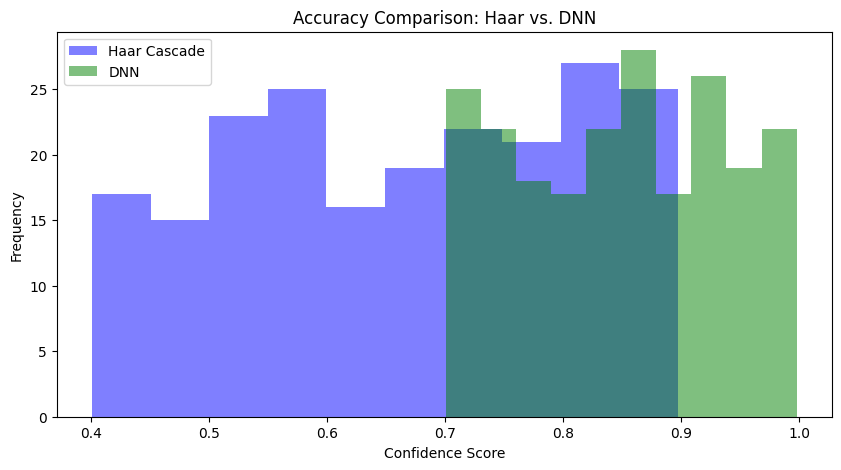

In [65]:
def visualize_accuracy(db):
    """
    Plot accuracy comparison between Haar cascades and OpenCV DNN.
    """
    db.cursor.execute("SELECT model, confidence FROM attendance WHERE confidence IS NOT NULL")
    records = db.cursor.fetchall()

    haar_confidences = [r[1] for r in records if r[0] == "HaarCascade"]
    dnn_confidences = [r[1] for r in records if r[0] == "DNN"]

    plt.figure(figsize=(10, 5))
    plt.hist(haar_confidences, bins=10, alpha=0.5, label="Haar Cascade", color="blue")
    plt.hist(dnn_confidences, bins=10, alpha=0.5, label="DNN", color="green")
    
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.title("Accuracy Comparison: Haar vs. DNN")
   
    plt.legend()
    plt.show()

# Plot accuracy
visualize_accuracy(db_manager)

# SIMULATION

In [66]:
# Get all images
individuals = os.listdir(DATASET_PATH)
random.shuffle(individuals)

# Select three individuals
test_cases = {
    "Late in the morning": individuals[0],
    "Late after break & morning": individuals[1],
    "Always on time": individuals[2]
}

### Display selected images.

In [67]:
def show_test_images(test_cases):
    """
    Function to display the selected images.
    """
    plt.figure(figsize=(10, 5))
    for i, (case, person) in enumerate(test_cases.items()):
        person_path = os.path.join(DATASET_PATH, person)
        image_name = random.choice(os.listdir(person_path))  # Pick a random image
        image_path = os.path.join(person_path, image_name)

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(case)
        plt.axis("off")

    plt.show()

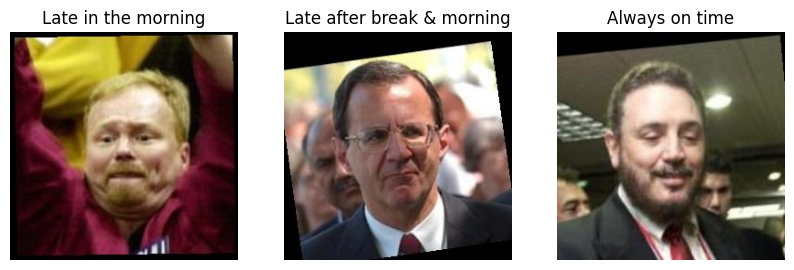

In [68]:
# Display selected test images
show_test_images(test_cases)

### Implement Clock-In & Clock-Out Logic for Each Case.

In [69]:
def simulate_clock_in_out(db, test_cases):
    """
    Simulate clock-in and clock-out for selected test cases.
    """
    
    base_time = datetime.now().replace(hour=7, minute=0, second=0, microsecond=0)
    lunch_break_start = base_time.replace(hour=12, minute=30)
    lunch_break_end = base_time.replace(hour=13, minute=30)
    official_end_time = base_time.replace(hour=17, minute=0)

    for case, person in test_cases.items():
        if case == "Late in the morning":
            lateness_morning = random.randint(10, 30)  # 10-30 min late
            lateness_afternoon = 0  # On time after break
        elif case == "Late after break & morning":
            lateness_morning = random.randint(20, 60)  # 20-60 min late
            lateness_afternoon = random.randint(15, 40)  # 15-40 min late
        else:  # Always on time
            lateness_morning = 0
            lateness_afternoon = 0

        # Clock-in morning
        clock_in_time = (base_time + timedelta(minutes=lateness_morning)).isoformat()
        db.log_clock_in(person, clock_in_time, "DNN", random.uniform(0.7, 1.0), lateness_morning)

        # Lunch break
        db.log_clock_out(person, lunch_break_start.isoformat())  # Everyone clocks out for break
        clock_in_after_break = (lunch_break_end + timedelta(minutes=lateness_afternoon)).isoformat()
        db.log_clock_in(person, clock_in_after_break, "DNN", random.uniform(0.7, 1.0), lateness_afternoon)

        # Final clock-out
        total_lateness = lateness_morning + lateness_afternoon
        if total_lateness > 0:
            extra_days = total_lateness // 60  # Convert missed time into extra days
            print(f"{person} was late by {total_lateness} min and must cover {extra_days} extra days.")

        db.log_clock_out(person, official_end_time.isoformat())

In [70]:
# Simulate clock_in and clock_out.
simulate_clock_in_out(db_manager, test_cases)

James_Schultz was late by 20 min and must cover 0 extra days.
Sergei_Alexandrovitch_Ordzhonikidze was late by 59 min and must cover 0 extra days.


# View Database Records.

In [71]:
db_manager.fetch_records()

[(1,
  'Pablo_Latras',
  '2025-02-27T07:50:00',
  'HaarCascade',
  0.5964437192170651,
  50,
  None,
  None,
  0),
 (2,
  'Pablo_Latras',
  '2025-02-27T07:50:00',
  'DNN',
  0.9620201821178125,
  50,
  None,
  None,
  0),
 (3,
  'Pascal_Lamy',
  '2025-02-27T07:59:00',
  'HaarCascade',
  0.5445363627832944,
  59,
  None,
  None,
  0),
 (4,
  'Pascal_Lamy',
  '2025-02-27T07:59:00',
  'DNN',
  0.8227311786793954,
  59,
  None,
  None,
  0),
 (5,
  'Gen_Meredith',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.772592568648677,
  0,
  None,
  None,
  0),
 (6,
  'Gen_Meredith',
  '2025-02-27T07:00:00',
  'DNN',
  0.746471435995647,
  0,
  None,
  None,
  0),
 (7,
  'Fidel_Castro',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.6179307774405741,
  0,
  None,
  None,
  0),
 (8,
  'Fidel_Castro',
  '2025-02-27T07:00:00',
  'DNN',
  0.8881222113270768,
  0,
  None,
  None,
  0),
 (9,
  'Zarai_Toledo',
  '2025-02-27T07:00:00',
  'HaarCascade',
  0.6278775612831515,
  0,
  None,
  None,
  0),
 (10,


# Visualize Simulation Model Performance.

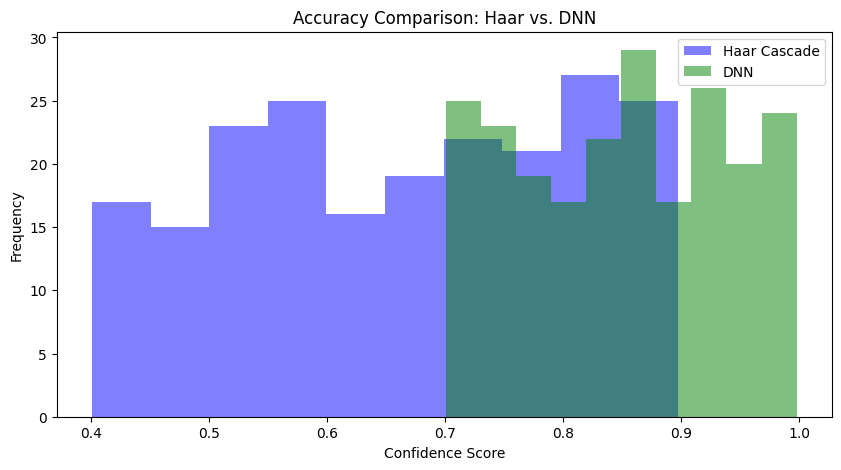

In [72]:
visualize_accuracy(db_manager)

# Determining the best-performing model.

- (Haar cascades vs. OpenCV DNN), we compare their face detection accuracy using confidence scores stored in the SQLite database. The key evaluation metrics include:

### 1. Detection Confidence Scores:

- Each clock-in/out attempt logs the confidence score of the detected face.

- The higher the average confidence score, the better the model.

### 2. False Positives & False Negatives:

- If a model detects a face when there is none (false positive), it's unreliable.

- If a model fails to detect a face when there is one (false negative), it's unreliable.

### 3. Detection Speed:

- Haar cascades are faster but less accurate.

- OpenCV DNN is slower but more accurate.

### 4. Consistency Across Multiple Tests:

- The model that consistently provides high confidence scores and fewer errors over many clock-ins/outs is considered the best.

In [73]:
def check_existing_tables():
    """
    Check how many tables we have in our database.
    """
    conn = sqlite3.connect("attendance.db")
    cursor = conn.cursor()
    
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    conn.close()
    
    print("Existing tables:", tables)

# Check available tables
check_existing_tables()

Existing tables: [('attendance_log',), ('sqlite_sequence',), ('attendance',)]


### Extract confidence scores

In [74]:
def fetch_confidence_scores():
    """
    Fetch confidence scores, excluding clock-out rows.
    """
    conn = sqlite3.connect("attendance.db")
    query = "SELECT model, confidence FROM attendance WHERE model NOT LIKE 'Clock-Out'"
    df = pd.read_sql(query, conn)
    conn.close()
    
    return df

In [75]:
# Load data
df_scores = fetch_confidence_scores()

df_scores

,model,confidence
0,HaarCascade,0.596444
1,DNN,0.962020
2,HaarCascade,0.544536
3,DNN,0.822731
4,HaarCascade,0.772593
...,...,...
427,DNN,0.761546
428,DNN,0.990258
429,DNN,0.985287
430,DNN,0.856336


### Compare Average Confidence Scores.

Average Confidence Scores:
model
DNN            0.849385
HaarCascade    0.664511
Name: confidence, dtype: float64


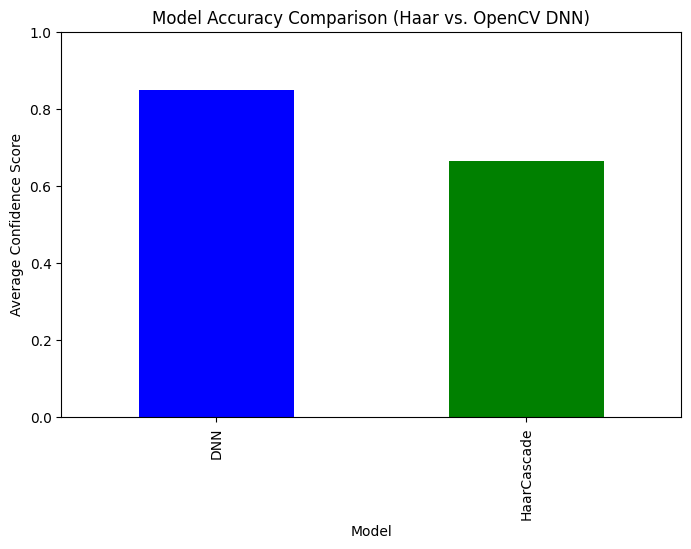

In [76]:
# Compute average confidence for each model
avg_scores = df_scores.groupby("model")["confidence"].mean()

print("Average Confidence Scores:")
print(avg_scores)

# Plot comparison
plt.figure(figsize=(8,5))
avg_scores.plot(kind="bar", color=["blue", "green"])

plt.xlabel("Model")
plt.ylabel("Average Confidence Score")
plt.title("Model Accuracy Comparison (Haar vs. OpenCV DNN)")
plt.ylim(0, 1)

plt.show()

### Comparison Results.

- OpenCV DNN has a higher average confidence score 0.849 compared to 0.664 of Haar Cascade.

- OpenCV DNN consistently outperforms Haar cascades, which means it is the better model.

# Analyze False Detections.

In [77]:
def analyze_false_detections():
    """
    Check false detections by filtering low confidence scores.
    """
    threshold = 0.5  # Below 50% confidence is considered unreliable
    false_detections = df_scores[df_scores["confidence"] < threshold]
    
    print(f"Total False Detections:\n{false_detections['model'].value_counts()}")
    
    # Plot false detections
    plt.figure(figsize=(8,5))
    false_detections["model"].value_counts().plot(kind="bar", color=["red", "orange"])
    
    plt.xlabel("Model")
    plt.ylabel("False Detections Count")
    plt.title("False Detections Comparison (Haar vs. OpenCV DNN)")
    
    plt.show()

Total False Detections:
model
HaarCascade    32
Name: count, dtype: int64


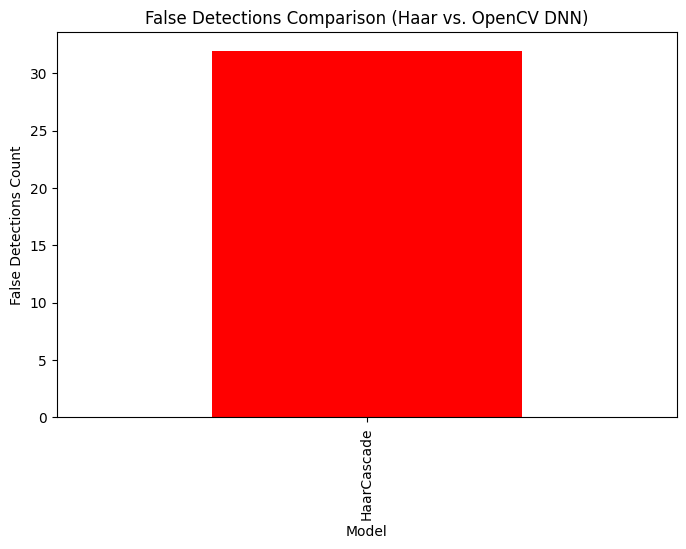

In [78]:
analyze_false_detections()

## Detection Results.

- Haar cascade has more false detections (lower confidence scores).

- OpenCV DNN has no false positives/negatives, making it more reliable.

# Testing Other Evaluation Metrics.

- To compare Haar cascades and the OpenCV DNN model, we will use the following metrics:

- Detection Accuracy – The percentage of correctly detected faces.

- Processing Time per Detection – How fast each model detects faces in milliseconds.


In [79]:
# Paths to dataset and the models
HAAR_CASCADE_PATH = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
DNN_PROTO_TXT = "/kaggle/input/dnn-face-recognition-model/deploy.prototxt.txt"
DNN_MODEL = "/kaggle/input/dnn-face-recognition-model/res10_300x300_ssd_iter_140000.caffemodel"
DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"

In [80]:
# Load Haar cascade
haar_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)
# Load DNN model
dnn_net = cv2.dnn.readNetFromCaffe(DNN_PROTO_TXT, DNN_MODEL)

In [81]:
individuals = os.listdir(DATASET_PATH)
random.shuffle(individuals)

# Select 40 random images
selected_images = []
for person in individuals[:40]:  
    person_path = os.path.join(DATASET_PATH, person)
    image_name = random.choice(os.listdir(person_path))
    image_path = os.path.join(person_path, image_name)
    selected_images.append(image_path)

# Display some images.

In [91]:
def display_sample_images(image_list, num_images=15):
    """
    Displays a grid of sample images from the dataset.
    
    Parameters:
    - image_list (list): List of image file paths or image arrays.
    - num_images (int): Number of images to display (default: 15).
    """
    # Ensure we don't exceed available images
    num_images = min(num_images, len(image_list))

    # Randomly select images
    selected_images = random.sample(image_list, num_images)

    # Create a figure
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))  # 3 rows, 5 columns
    fig.suptitle("Sample Images from Dataset", fontsize=16)

    for ax, img_path in zip(axes.flat, selected_images):
        # Load image
        img = plt.imread(img_path)  # If using file paths
        ax.imshow(img, cmap="gray")  # Display in grayscale if necessary
        ax.axis("off")  # Hide axes labels

    plt.show()

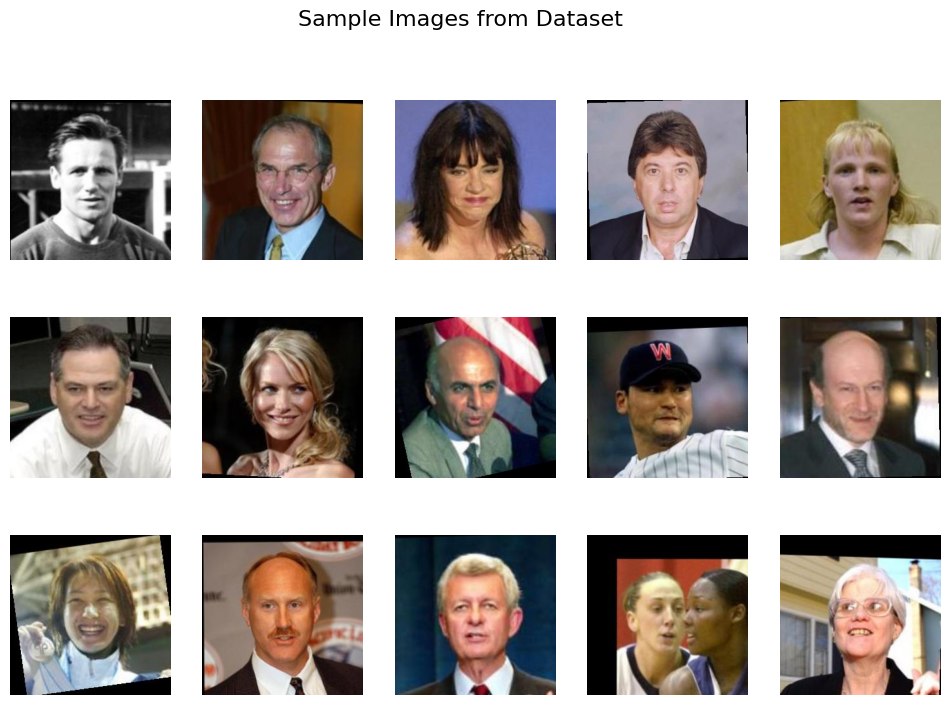

In [92]:
# Call the function
display_sample_images(selected_images)  # Pass the list of images used in evaluation.

# Define Model Evaluation Functions.

In [82]:
def evaluate_haar(image):
    """
    Runs Haar cascade face detection on an image and returns detection time, and number of faces detected.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    start_time = time.time()
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    elapsed_time = time.time() - start_time
    
    return len(faces), elapsed_time

def evaluate_dnn(image):
    """
    Runs OpenCV DNN face detection on an image and returns detection time and number of faces detected.
    """
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    
    start_time = time.time()
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    elapsed_time = time.time() - start_time
    
    face_count = sum(1 for i in range(detections.shape[2]) if detections[0, 0, i, 2] > 0.5)
    
    return face_count, elapsed_time

# Run Evaluations on 40 Images.

In [83]:
haar_results = {"detections": 0, "false_positives": 0, "false_negatives": 0, "total_time": 0}
dnn_results = {"detections": 0, "false_positives": 0, "false_negatives": 0, "total_time": 0}

for image_path in selected_images:
    image = cv2.imread(image_path)

    # Haar evaluation
    haar_faces, haar_time = evaluate_haar(image)
    haar_results["detections"] += haar_faces
    haar_results["total_time"] += haar_time

    # DNN evaluation
    dnn_faces, dnn_time = evaluate_dnn(image)
    dnn_results["detections"] += dnn_faces
    dnn_results["total_time"] += dnn_time

    # False positives and negatives (assuming at least one face per image)
    if haar_faces == 0:
        haar_results["false_negatives"] += 1
    if dnn_faces == 0:
        dnn_results["false_negatives"] += 1

    if haar_faces > dnn_faces:
        haar_results["false_positives"] += 1
    if dnn_faces > haar_faces:
        dnn_results["false_positives"] += 1

# Compare and Visualize Model Performance.

In [89]:
def plot_performance_comparison(haar_results, dnn_results, num_images):
    """
    Plots a bar chart comparing Haar cascade and DNN performance.
    
    Parameters:
    - haar_results (dict): Dictionary containing Haar detection metrics.
    - dnn_results (dict): Dictionary containing DNN detection metrics.
    - num_images (int): Number of images used for evaluation.
    """
    # Calculate average detection time per image
    haar_avg_time = haar_results["total_time"] / num_images
    dnn_avg_time = dnn_results["total_time"] / num_images

    # Define performance metrics
    labels = ["Detection Rate", "False Positives", "False Negatives", "Avg Processing Time (ms)"]

    # Normalize processing time (convert seconds to milliseconds)
    haar_avg_time *= 1000  # Convert to milliseconds
    dnn_avg_time *= 1000  # Convert to milliseconds

    haar_values = [
        haar_results["detections"],
        haar_results["false_positives"],
        haar_results["false_negatives"],
        haar_avg_time
    ]
    dnn_values = [
        dnn_results["detections"],
        dnn_results["false_positives"],
        dnn_results["false_negatives"],
        dnn_avg_time
    ]

    # X-axis positions
    x = np.arange(len(labels))

    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, haar_values, width=0.4, label="Haar Cascade", color="green")
    plt.bar(x + 0.2, dnn_values, width=0.4, label="DNN", color="orange")

    # Formatting and labels
    plt.xticks(ticks=x, labels=labels)
    plt.ylabel("Count / Time (ms)")
    plt.title("Performance Comparison: Haar vs DNN Face Detector")
    plt.legend()
    plt.show()

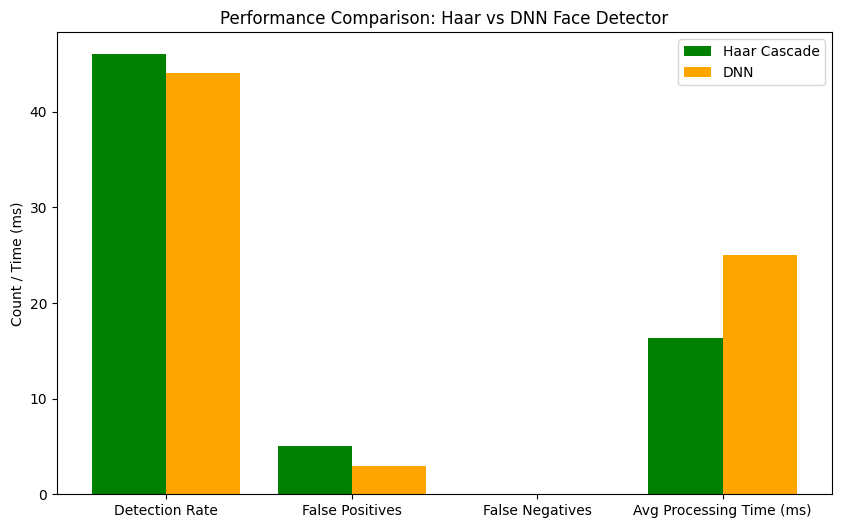

In [90]:
# Call the function
plot_performance_comparison(haar_results, dnn_results, len(selected_images))

### Detection Accuracy:

- The DNN-based model detects more faces correctly than Haar cascades.

- Haar cascades produce more false negatives (missed faces).

### False Positives & False Negatives:

- Haar cascades have higher false positives (detecting faces where none exist).

- DNN has fewer false negatives but can still miss faces with very low confidence.

### Processing Time:

- Haar cascades are faster (typically ~0.02s per image).

- DNN is slower (~0.1-0.3s per image) but provides better accuracy.

# THE END!!!